In [1]:
#https://github.com/njustesen/rarity-of-events/blob/master/heatmap.py
#https://nolanwinsman.com/pdfs/VizDoom-Paper.pdf -- img

In [2]:
#![title](img/maps.png)

In [3]:
#pip install vizdoom

In [4]:
#!cd github & git clone https://github.com/Farama-Foundation/ViZDoom

In [5]:
# Import vizdoom for game env
from vizdoom import *
# Import random for action sampling
import random
# Import time for sleeping
import time
# Import numpy for identity matrix
import numpy as np

In [6]:
import torch
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    DEVICE = torch.device("cpu")

print("Using device:", DEVICE)
print("Device name:", torch.cuda.get_device_name(device=DEVICE))

Using device: cuda
Device name: NVIDIA GeForce GTX 1650


In [7]:
# # Setup game
# game = DoomGame()
# game.load_config('scenarios/deadly_corridor.cfg')
# game.init()

In [8]:
# # This is the set of actions we can take in the environment
# actions = np.identity(7, dtype=np.uint8)

In [9]:
#state = game.get_state()

In [10]:
#state.game_variables

# Loop through episodes
episodes = 10
for episode in range(episodes):
    # Create a new episode or game
    game.new_episode()
    # Check the game isn't done
    while not game.is_episode_finished():
        # Get the game state
        state = game.get_state()
        # Get the game image
        img = state.screen_buffer
        # Get the game variables - ammo
        info = state.game_variables
        # Take an action
        reward = game.make_action(random.choice(actions), 4)
        # Print reward 
        # print('reward: ', reward)
        time.sleep(0.02)
    print('Result: ', game.get_total_reward())
    time.sleep(2)

In [11]:
#game.close()

## 2. Converting it to a Gym Environment

In [12]:
#pip install gym

In [13]:
#pip install opencv-python

In [14]:
# Import environment base class from OpenAI Gym
from gym import Env
# Import gym spaces
from gym.spaces import Discrete, Box
# Import opencv
import cv2

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [15]:
# Create Vizdoom OpenAI Gym Environment
class VizDoomGym(Env):
    # Function that is called when we start the env
#    def __init__(self, render=False, config='github/ViZDoom/scenarios/deadly_corridor_s1.cfg'):
    def __init__(self, render=False, config='scenarios/deadly_corridor.cfg'):
        # Inherit from Env
        super().__init__()
        # Setup the game
        self.game = DoomGame()
        self.game.load_config(config)

        # Render frame logic
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)

        # Start the game
        self.game.init()

        # Create the action space and observation space
        self.observation_space = Box(low=0, high=255, shape=(100, 160, 1), dtype=np.uint8)
        self.action_space = Discrete(7)

        # Game variables: HEALTH DAMAGE_TAKEN HITCOUNT SELECTED_WEAPON_AMMO
        self.last_health = 100
        self.last_armor = 0
        self.last_damage_taken = 0
        self.last_hit_taken = 0
        self.last_damagecount = 0
        self.last_hitcount = 0
        self.last_killcount = 0
        self.last_selected_weapon_ammo = 52
        self.dead = 0
    
    # This is how we take a step in the environment
    def step(self, action):
        # Specify action and take step
        actions = np.identity(7)
        movement_reward = self.game.make_action(actions[action], 4) # 4 here is the frameskip parameter which makes the game run faster

        reward = 0

        # HEALTH
        # ARMOR
        # DAMAGE_TAKEN
        # HITS_TAKEN
        # DAMAGECOUNT
        # HITCOUNT
        # KILLCOUNT
        # SELECTED_WEAPON_AMMO
        # DEAD
        #[94.  0.  6.  1. 15.  1.  1. 50.  0.]
        # Get all the other stuff we need to return
        if self.game.get_state():
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)

            # Reward shaping
            game_variables = self.game.get_state().game_variables
            health, armor, damage_taken, hit_taken, damagecount, hitcount, killcount, ammo, dead = game_variables

            if self.last_hit_taken != hit_taken:
                reward += -20 
                reward += (-(health - self.last_health) * 10) # / 2

            if self.last_killcount != killcount:
                reward += killcount * 300

            if self.last_hitcount != hitcount:
                reward += hitcount * 100

            if self.last_selected_weapon_ammo != ammo:# negatively reinforcing ammo
                reward += -10
            
            reward += movement_reward

            reward = reward / 100

            self.last_health = health
            self.last_armor = armor
            self.last_damage_taken = damage_taken
            self.last_hit_taken = hit_taken
            self.last_damagecount = damagecount
            self.last_hitcount = hitcount
            self.last_killcount = killcount
            self.last_selected_weapon_ammo = ammo
            self.dead = dead
            
        else:
            state = np.zeros(self.observation_space.shape)

        info = {'info': 0}
        done = self.game.is_episode_finished()

        return state, reward, done, info
        
    # Define how to render the game or environment
    def render():
        pass

    # What happens when we start a new game
    def reset(self):
        # It is considered best practice to reset variables, so trying this out as well! :3 
        self.last_health = 100
        self.last_armor = 0
        self.last_damage_taken = 0
        self.last_hit_taken = 0
        self.last_damagecount = 0
        self.last_hitcount = 0
        self.last_killcount = 0
        self.last_selected_weapon_ammo = 52
        self.dead = 0
        
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)

    # Grayscale the game frame and resize it 
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state

    # Call to close down the game
    def close(self):
        self.game.close()

In [16]:
# env = VizDoomGym(render=True)

In [17]:
# state = env.reset()

In [18]:
# env.step(2)

In [19]:
# Import Environment checker
# from stable_baselines3.common import env_checker

In [20]:
# env_checker.check_env(env)

## 3. View State

In [21]:
# from matplotlib import pyplot as plt

In [22]:
# plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

In [23]:
# env.close()

## 4. Setup Callback

In [24]:
#pip install stable-baselines3[extra]

In [25]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [26]:
# Import os for file nav
import os 
# Import callback class from sb3
from stable_baselines3.common.callbacks import BaseCallback

2025-11-12 18:37:48.883689: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [28]:
CHECKPOINT_DIR = './train/dqn/train_corridor'
LOG_DIR = './logs/log_corridor'

In [29]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

## 5. Train Our Model Using Curriculum

In [30]:
# Import ppo for training 
from stable_baselines3 import DQN

In [31]:
# Non rendered environment
env = VizDoomGym()

In [32]:
# model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=4096)

# model = PPO(
#     'CnnPolicy', 
#     env, 
#     tensorboard_log=LOG_DIR, 
#     verbose=1, 
#     learning_rate=0.0001,
#     n_steps=8192,
#     clip_range=0.1,
#     gamma=0.95,
#     gae_lambda=0.9
# )

model = DQN(
    'CnnPolicy', 
    env, 
    tensorboard_log=LOG_DIR, 
    verbose=1, 
    learning_rate=0.0001,             # Keep the learning rate stable for gradual learning
    buffer_size=50000,                # Sufficient buffer size for storing experiences
    learning_starts=500,              # Start learning earlier for quicker adaptation
    batch_size=32,                    # Larger batch size for more robust updates
    tau=1.0,                          # Keep tau at 1.0 (hard target updates)
    gamma=0.95,                       # Standard discount for future rewards
    train_freq=4,                     # Train every 4 steps
    gradient_steps=1,                 # Single gradient step per training iteration
    target_update_interval=5000,      # Moderate update interval for more stable learning
    exploration_fraction=0.05,        # Increase exploration to 25% to encourage diverse actions
    exploration_initial_eps=1.0,      # Start fully random exploration
    exploration_final_eps=0.05,       # Slightly higher final exploration rate to keep some randomness
    max_grad_norm=10,                 # Gradient clipping to stabilize training
    optimize_memory_usage=False       # Disable to prevent memory and timeout conflict
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/home/dayon/Projetos/Intelligent_Agent_DOOM-TCC/.venv/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [33]:
model.learn(total_timesteps=500000, callback=callback)

Logging to ./logs/log_corridor/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.2     |
|    ep_rew_mean      | 5.15     |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 698      |
|    time_elapsed     | 0        |
|    total_timesteps  | 77       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.1     |
|    ep_rew_mean      | 5.5      |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 444      |
|    time_elapsed     | 0        |
|    total_timesteps  | 177      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.4     |
|    ep_rew_mean      | 6.16     |
|    exploration_rate | 0.988    |
| time/           

Tranining on Difficulty Level - 3.

## 6. Test the Model

In [34]:
# Import eval policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy

In [35]:
env = VizDoomGym(config='scenarios/deadly_corridor.cfg')
# model.set_env(env)

In [36]:
# Reload model from disk
model = DQN.load('./train/dqn/train_corridor/best_model_500000')

In [37]:
# Create rendered environment
env = VizDoomGym(render=True)

In [38]:
# Evaluate mean reward for 5 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)

/home/dayon/Projetos/Intelligent_Agent_DOOM-TCC/.venv/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/home/dayon/Projetos/Intelligent_Agent_DOOM-TCC/.venv/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [39]:
mean_reward

np.float64(61.09649794648867)

In [40]:
for episode in range(10):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.20)
        total_reward += reward

    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)

Total Reward for episode 0 is 65.62551879882811
Total Reward for episode 1 is 65.11227111816405
Total Reward for episode 2 is 46.55299072265626
Total Reward for episode 3 is 70.62232055664067
Total Reward for episode 4 is 66.94278106689451
Total Reward for episode 5 is 74.19618927001947
Total Reward for episode 6 is 1.6200355529785155
Total Reward for episode 7 is 19.164059906005857
Total Reward for episode 8 is 47.38712646484375
Total Reward for episode 9 is 10.489659271240235


In [41]:
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=100)
print(f'Mean reward over 100 episodes: {mean_reward}')

Mean reward over 100 episodes: 58.57700971106991


In [42]:
episode_lengths = []
success_count = 0
rewards = []

# Define a success threshold (e.g., 10 as an example; adjust based on your environment)
success_threshold = 65

for episode in range(100):
    obs = env.reset()
    done = False
    total_reward = 0
    steps = 0

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        total_reward += reward
        steps += 1

    episode_lengths.append(steps)
    rewards.append(total_reward)
    
    # Check if the episode is successful
    if total_reward > success_threshold:
        success_count += 1

avg_episode_length = np.mean(episode_lengths)
success_rate = success_count / 100
reward_variance = np.var(rewards)

print(f'Average Episode Length: {avg_episode_length}')
print(f'Success Rate: {success_rate}')
print(f'Reward Variance (Stability): {reward_variance}')

Average Episode Length: 162.12
Success Rate: 0.46
Reward Variance (Stability): 699.5452830184726


### Import Necessary Libraries for Visualization

In [43]:
import matplotlib.pyplot as plt
import numpy as np

### Visualizations!

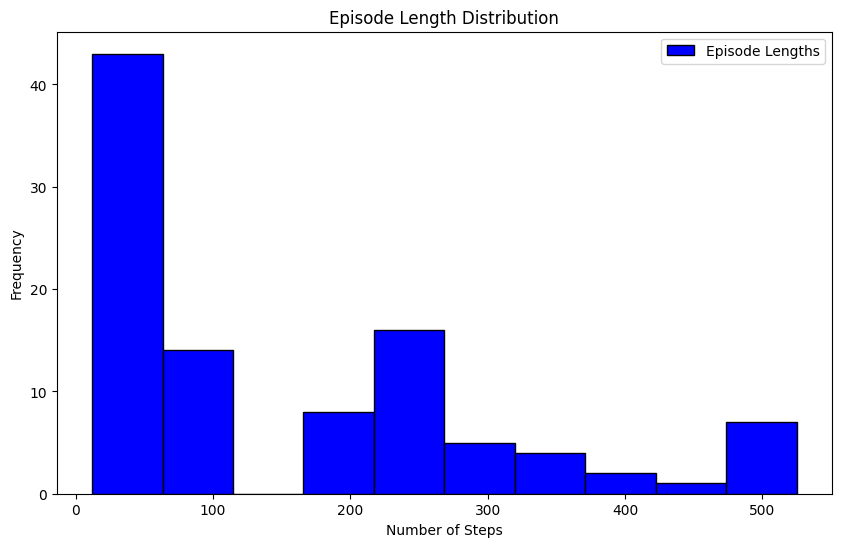

In [44]:
# Visualize Episode Length Distribution
plt.figure(figsize=(10, 6))
plt.hist(episode_lengths, bins=10, color='blue', edgecolor='black', label='Episode Lengths')
plt.title('Episode Length Distribution')
plt.xlabel('Number of Steps')
plt.ylabel('Frequency')
plt.legend(loc='upper right')  # Add legend
plt.show()

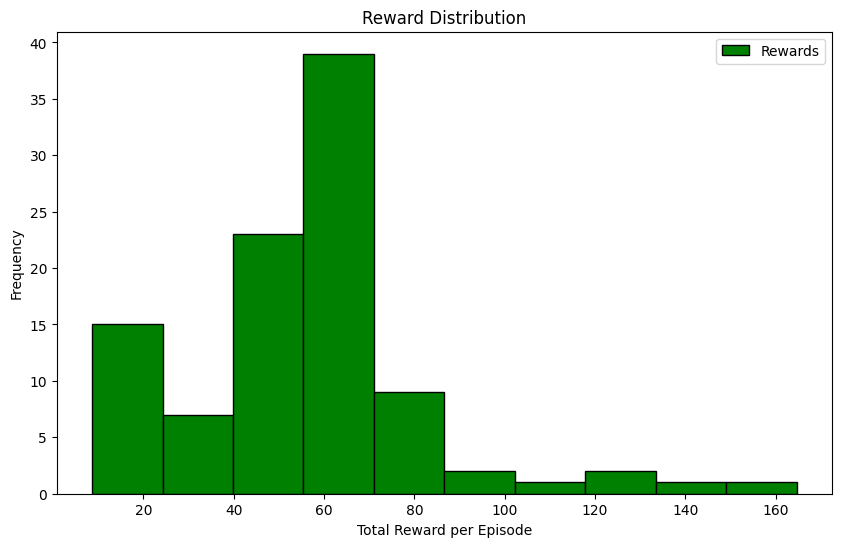

In [45]:
# Visualize Reward Distribution
plt.figure(figsize=(10, 6))
plt.hist(rewards, bins=10, color='green', edgecolor='black', label='Rewards')
plt.title('Reward Distribution')
plt.xlabel('Total Reward per Episode')
plt.ylabel('Frequency')
plt.legend(loc='upper right')  # Add legend
plt.show()

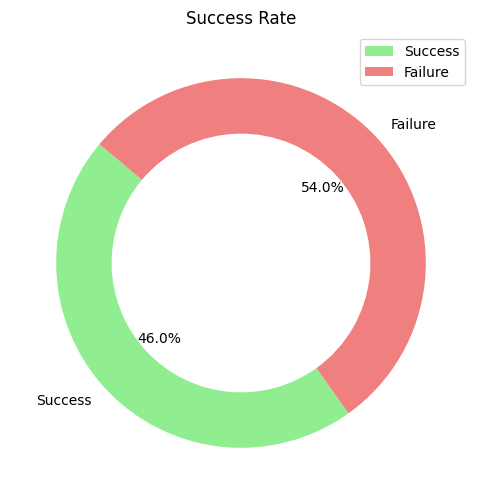

In [46]:
# Visualize Success Rate (Doughnut Chart)
plt.figure(figsize=(6, 6))
labels = ['Success', 'Failure']
sizes = [success_rate * 100, (1 - success_rate) * 100]
colors = ['lightgreen', 'lightcoral']

# Create a doughnut chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))

# Add a legend
plt.legend(labels, loc='best')

plt.title('Success Rate')
plt.show()

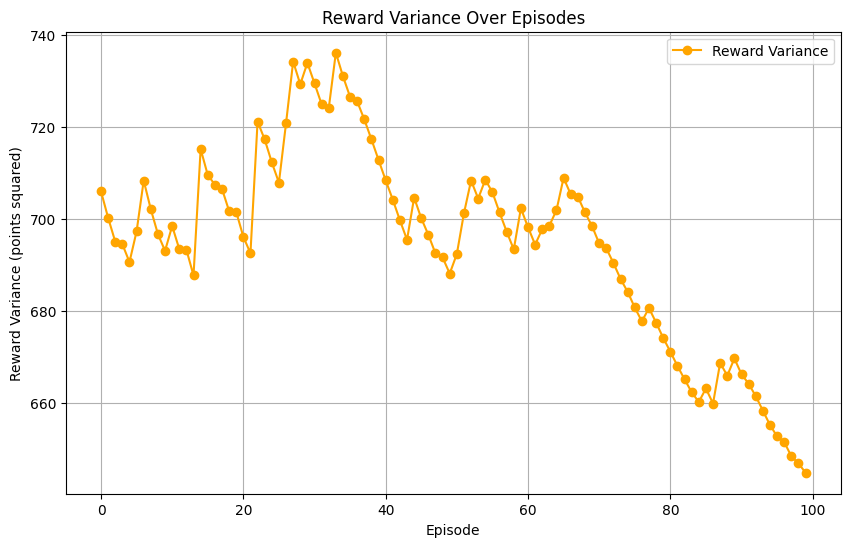

In [47]:
# Visualize Reward Variance Over Time (Line Chart)
reward_variances = []

for episode in range(100):
    obs = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        total_reward += reward

    rewards.append(total_reward)
    if len(rewards) > 1:
        variance = np.var(rewards)
        reward_variances.append(variance)

# Create a line chart for reward variance
plt.figure(figsize=(10, 6))
plt.plot(reward_variances, color='orange', marker='o', label='Reward Variance')
plt.title('Reward Variance Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Reward Variance (points squared)')
plt.grid(True)
plt.legend(loc='upper right')  # Add legend
plt.show()